# Transformer를 이용해 Question Answering task 수행하기


In [ ]:
!pip install -U transformers==4.48.0
!pip install -U datasets
!pip install -U bitsandbytes
!pip install -U accelerate
!pip install -U peft
!pip install -U wandb

Defaulting to user installation because normal site-packages is not writeable
Looking in indexes: http://repo.ai.gato/registry/repository/pypi-proxy/simple
  Using cached http://repo.ai.gato/registry/repository/pypi-proxy/packages/transformers/4.48.0/transformers-4.48.0-py3-none-any.whl (9.7 MB)
Defaulting to user installation because normal site-packages is not writeable
Looking in indexes: http://repo.ai.gato/registry/repository/pypi-proxy/simple
  Using cached http://repo.ai.gato/registry/repository/pypi-proxy/packages/fsspec/2024.12.0/fsspec-2024.12.0-py3-none-any.whl (183 kB)
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
cudf-cu12 24.12.0 requires numba-cuda<0.0.18,>=0.0.13, which is not installed.
s3fs 2025.2.0 requires fsspec==2025.2.0.*, but you have fsspec 2024.12.0 which is incompatible.
cudf-cu12 24.12.0 requires pyarrow<19.0.0a0,>=14.0.0; platform

In [ ]:
import transformers
print(transformers.__version__)

4.49.0


In [ ]:
import os
import torch
import numpy as np
import matplotlib.pyplot as plt
from transformers import AutoTokenizer, AutoModelForCausalLM, TrainingArguments, Trainer, BitsAndBytesConfig, get_linear_schedule_with_warmup
from datasets import load_dataset
from peft import LoraConfig, get_peft_model, prepare_model_for_kbit_training
from tqdm.auto import tqdm
from huggingface_hub import login

In [ ]:
login("secret")

## 1. 데이터 전처리
- 사용해야 할 데이터는 **KorQuAD(Korean Question Answering Dataset)**로, 한국어로 된 질문과 답변 쌍을 포함하고 있으며 주어진 문서 내에서 관련된 정보를 찾아 답을 생성할 수 있도록 하는 데이터셋입니다.
- 질문에 대한 **답이 항상 주어진 지문 안**에 있는 것이 특징입니다.
- 저는 지문을 이해는게 중요하다고 생각하여 transformer의 encoder부분을 차용하는 bert기반의 **klue/bert-base**를 사용하였습니다.
- LG CNS에 의해 공개되었으며 이번 task에 사용하는 dataset은 version1이지만 version2에는 표가 지문에 등장하는 등 복잡한 질문 유형도 포함되었다고 합니다.


In [ ]:
dataset = load_dataset("squad_kor_v1")
print(dataset)

DatasetDict({
    train: Dataset({
        features: ['id', 'title', 'context', 'question', 'answers'],
        num_rows: 60407
    })
    validation: Dataset({
        features: ['id', 'title', 'context', 'question', 'answers'],
        num_rows: 5774
    })
})


데이터셋은 고유 id, 내용의 제목, 내용, 질문, 답변, 답변의 시작 위치(문자열 기준)정보가 담겨있었습니다.

In [ ]:
dataset["train"][0]

{'id': '6566495-0-0',
 'title': '파우스트_서곡',
 'context': '1839년 바그너는 괴테의 파우스트을 처음 읽고 그 내용에 마음이 끌려 이를 소재로 해서 하나의 교향곡을 쓰려는 뜻을 갖는다. 이 시기 바그너는 1838년에 빛 독촉으로 산전수전을 다 걲은 상황이라 좌절과 실망에 가득했으며 메피스토펠레스를 만나는 파우스트의 심경에 공감했다고 한다. 또한 파리에서 아브네크의 지휘로 파리 음악원 관현악단이 연주하는 베토벤의 교향곡 9번을 듣고 깊은 감명을 받았는데, 이것이 이듬해 1월에 파우스트의 서곡으로 쓰여진 이 작품에 조금이라도 영향을 끼쳤으리라는 것은 의심할 여지가 없다. 여기의 라단조 조성의 경우에도 그의 전기에 적혀 있는 것처럼 단순한 정신적 피로나 실의가 반영된 것이 아니라 베토벤의 합창교향곡 조성의 영향을 받은 것을 볼 수 있다. 그렇게 교향곡 작곡을 1839년부터 40년에 걸쳐 파리에서 착수했으나 1악장을 쓴 뒤에 중단했다. 또한 작품의 완성과 동시에 그는 이 서곡(1악장)을 파리 음악원의 연주회에서 연주할 파트보까지 준비하였으나, 실제로는 이루어지지는 않았다. 결국 초연은 4년 반이 지난 후에 드레스덴에서 연주되었고 재연도 이루어졌지만, 이후에 그대로 방치되고 말았다. 그 사이에 그는 리엔치와 방황하는 네덜란드인을 완성하고 탄호이저에도 착수하는 등 분주한 시간을 보냈는데, 그런 바쁜 생활이 이 곡을 잊게 한 것이 아닌가 하는 의견도 있다.',
 'question': '바그너는 괴테의 파우스트를 읽고 무엇을 쓰고자 했는가?',
 'answers': {'text': ['교향곡'], 'answer_start': [54]}}

아래 코드는 데이터셋을 BERT 모델에 입력할 수 있도록 전처리 하는 과정입니다.

QA TASK를 수행하기 위해서는 질문과 문맥을 하나의 입력 시퀀스로 결합해야 하며, 정답의 시작과 끝 위치를 토큰 단위로 변화해야 합니다.

**1. bert의 입력 형식에 맞게 결합**
- BERT 모델에서는 [CLS] 질문 [SEP] 문맥 [SEP] 형태로 입력을 받습니다.
- tokenizer를 통하여 질문과 문맥을 함께 토큰화하고, max_length를 제한하여 길이를 조정하였습니다.
- 길이를 자르는 것은 두번째, 즉 문맥에만 적용되게 하여 질문이 잘려 보지 못하는 일은 발생하지 않도록 하였습니다.
- 문맥이 너무 길어 512토큰을 초과하는 경우에는 stride를 사용하여 오버랩된 슬라이딩 윈도우 방식으로 나누었습니다.
- overflow_to_sampling_mapping을 사용해 나눠진 청크가 어떤 문장에서 나왔는지 추적할 수 있게 하였습니다.
- 잘린 문맥에 정답이 없는 경우 [CLS]토큰을 정답으로 학습하게 하였습니다.



**2. 정답의 시작, 끝 위치를 토큰 단위로 변환**
- 본래 char단위의 위치를 토큰 단위의 위치로 변화시키기 위하여 offset_mapping을 사용해 정답의 시작, 끝 위치를 찾아내었습니다.
>offset mapping은 각 토큰이 원래 텍스트에서 차지하는 문자 단위의 위치(start, end)를 제공하는 리스트

    >ex)Offset Mapping: [(0, 0), (0, 2), (2, 4), (5, 7), (7, 8), (9, 10), (10, 12), (12, 13), (0, 0), (0, 2), (3, 5), (5, 7), (8, 10), (10, 11), (0, 0)]

    -> 0은 sep, cls토큰



In [ ]:
from transformers import AutoTokenizer

# klue-bert모델의 토크나이저 사용
tokenizer = AutoTokenizer.from_pretrained("klue/bert-base")

def prepare_train_features(examples):
    tokenized_examples = tokenizer(examples["question"],
                                   examples["context"],
                                   truncation="only_second",
                                   max_length=512,
                                   stride=128, # 문맥을 자를 때 겹치는 부분을 128로 유지 -> 정답 손실 방지
                                   return_overflowing_tokens=True, # 긴 문맥을 청크로 나누고 매핑
                                   return_offsets_mapping=True, # 각 토큰이 원본 데이터에서 차지하는 문자 위치 정보
                                   padding="max_length") # 패딩을 512만큼

    # 매핑 정보, 토큰 위치 리스트 가져오기
    sample_mapping = tokenized_examples.pop("overflow_to_sample_mapping")
    offset_mapping = tokenized_examples.pop("offset_mapping")

    # 시작, 끝 위치 리스트 생성
    tokenized_examples["start_positions"] = []
    tokenized_examples["end_positions"] = []

    # 청크별로 정답 위치 찾기
    for i, offsets in enumerate(offset_mapping):
        input_ids = tokenized_examples["input_ids"][i]
        cls_index = input_ids.index(tokenizer.cls_token_id)

        # sequence_ids에는 질문(0)과 문맥(1)이 들어있음
        sequence_ids = tokenized_examples.sequence_ids(i)

        # 청크가 어느 원본 데이터에서 왔는지 확인
        sample_index = sample_mapping[i]
        # 원본 데이터의 정답 데이터를 가져옴
        answers = examples["answers"][sample_index]

        # 만약 정답이 없는 경우 [CLS]의 위치를 정답 위치로 저장
        if len(answers["answer_start"]) == 0:
            tokenized_examples["start_positions"].append(cls_index)
            tokenized_examples["end_positions"].append(cls_index)
        else:
            # 토크나이징 하기 전 정답 시작, 끝 인덱스 가져옴
            start_char = answers["answer_start"][0]
            end_char = start_char + len(answers["text"][0])

            # context가 시작하는 첫 번째 토큰 위치 찾기 (sequence id가 0인 부분 건너 뛰며 길이 알아내기)
            token_start_index = 0
            while sequence_ids[token_start_index] != 1:
                token_start_index += 1

            # context가 끝나는 마지막 토큰 위치 찾기 (거꾸로 mask가 아닌 부분 찾기, mask는 0)
            token_end_index = len(input_ids) - 1
            while sequence_ids[token_end_index] != 1:
                token_end_index -= 1

            # 정답이 현재 청크에 포함되지 않는 경우 [CLS]를 정답으로 (offset을 활용해 캐릭터 단위로 index 비교)
            if not (offsets[token_start_index][0] <= start_char and offsets[token_end_index][1] >= end_char):
                tokenized_examples["start_positions"].append(cls_index)
                tokenized_examples["end_positions"].append(cls_index)
            else:
                # 정답 시작 위치를 토큰 인덱스로 변환
                while token_start_index < len(offsets) and offsets[token_start_index][0] <= start_char:
                    token_start_index += 1
                tokenized_examples["start_positions"].append(token_start_index - 1)
                # 정답 끝 위치를 토큰 인덱스로 변환
                while offsets[token_end_index][1] >= end_char:
                    token_end_index -= 1
                tokenized_examples["end_positions"].append(token_end_index + 1)

    return tokenized_examples

# train, val dataset batch단위로 한 번에 여러 샘플 처리
tokenized_train_dataset = dataset["train"].map(prepare_train_features, batched=True, remove_columns=dataset["train"].column_names)

tokenized_val_dataset = dataset["validation"].map(prepare_train_features, batched=True, remove_columns=dataset["validation"].column_names)

tokenized_datasets = {
    "train": tokenized_train_dataset,
    "validation": tokenized_val_dataset
}

print(tokenized_datasets)


Map:   0%|          | 0/60407 [00:00<?, ? examples/s]

Map:   0%|          | 0/5774 [00:00<?, ? examples/s]

{'train': Dataset({
    features: ['input_ids', 'token_type_ids', 'attention_mask', 'start_positions', 'end_positions'],
    num_rows: 62909
}), 'validation': Dataset({
    features: ['input_ids', 'token_type_ids', 'attention_mask', 'start_positions', 'end_positions'],
    num_rows: 6155
})}


- input_ids : 토크나이징된 단어의 ID
- token_type_ids : 질문 0, 본문 1로 구분해주는 역할
- attention_mask : 내용 1, 패딩 0으로 구분해주는 역할
- start_positions : 토큰의 시작 위치
- end_positions : 토큰의 마지막 위치

In [ ]:
print(tokenized_datasets['train'][0])

{'input_ids': [2, 27982, 2259, 21310, 2079, 11994, 3791, 2138, 1508, 2088, 3890, 2069, 1363, 2088, 2155, 1902, 2259, 2116, 35, 3, 13934, 2236, 2440, 27982, 2259, 21310, 2079, 11994, 3791, 2069, 3790, 1508, 2088, 636, 3800, 2170, 3717, 2052, 9001, 8345, 4642, 2200, 3689, 3657, 2079, 19282, 2069, 1363, 2370, 2259, 936, 2069, 554, 2259, 2062, 18, 1504, 4342, 27982, 2259, 13934, 2196, 2440, 2170, 1195, 23260, 6233, 17370, 2113, 2165, 2069, 809, 1, 3706, 2052, 2181, 8642, 2145, 7334, 2170, 4983, 2371, 4007, 1065, 5917, 2386, 2559, 4443, 2138, 4026, 2259, 11994, 3791, 2079, 15864, 2170, 5487, 2371, 4683, 3605, 18, 3819, 5986, 27135, 1376, 2645, 2203, 2292, 2079, 5872, 2200, 5986, 4152, 2252, 22835, 16706, 2052, 5485, 2205, 2259, 17087, 2079, 19282, 29, 2517, 2069, 881, 2088, 652, 2073, 23404, 2069, 1122, 2886, 13964, 16, 3982, 2052, 9944, 21, 2429, 2170, 11994, 3791, 2079, 1258, 2465, 6233, 24294, 1504, 3967, 2170, 4027, 2052, 5121, 3979, 2069, 18274, 21575, 23548, 575, 2073, 5292, 2085, 725

이렇게 만들어진 데이터 개수를 확인해 보았을 때, sliding window방식으로 생성된 train 데이터셋이 약 2500개 정도 된다는 것을 알게 되었습니다.

In [ ]:
print(f"훈련 데이터 개수: {len(dataset['train'])}")
print(f"검증 데이터 개수: {len(dataset['validation'])}")

훈련 데이터 개수: 60407
검증 데이터 개수: 5774


In [ ]:
print(f"전처리 후 훈련 데이터 개수: {len(tokenized_datasets['train'])}")
print(f"전처리 후 검증 데이터 개수: {len(tokenized_datasets['validation'])}")

전처리 후 훈련 데이터 개수: 62909
전처리 후 검증 데이터 개수: 6155


In [ ]:
import random

def check_sample(dataset, tokenizer, idx=None):
    if idx is None:
        idx = random.randint(0, len(dataset) - 1)

    sample = dataset[idx]

    # 원본 텍스트 출력
    print("Original Question:", tokenizer.decode(sample['input_ids'], skip_special_tokens=True))

    # 토큰화된 입력 확인
    print("\nTokenized input:")
    print(tokenizer.convert_ids_to_tokens(sample['input_ids']))

    # 답변 위치 확인
    start_pos = sample['start_positions']
    end_pos = sample['end_positions']
    print(f"\nAnswer start position: {start_pos}")
    print(f"Answer end position: {end_pos}")

    # 예측된 답변 출력
    predicted_answer = tokenizer.decode(sample['input_ids'][start_pos:end_pos+1])
    print(f"\nPredicted answer: {predicted_answer}")

    # 답변이 문맥 내에 있는지 확인
    context_start = sample['input_ids'].index(tokenizer.sep_token_id) + 1
    if start_pos >= context_start and end_pos >= context_start:
        print("Answer is within the context.")
    else:
        print("Warning: Answer position is not within the context.")

# 데이터셋에서 무작위로 5개의 샘플 확인
for _ in range(5):
    print("\n" + "="*50)
    check_sample(tokenized_datasets['train'], tokenizer)



Original Question: 롤링의 증조할아버지의 국적은 무엇인가? 롤링은 1965년 7월 31일 잉글랜드 브리스틀 근처 북동쪽에서 10 마일 ( 16. 1 km ) 떨어진 예이트 ( Yate ) 에서 롤스로이스 항공기 엔지니어 였던 " 피터 제임스 롤링 " 과 과학 기술자의 앤 롤링 ( 옛 성씨 : 볼란트 ) 의 장녀로 태어났다. 그녀의 부모는 1964년 아브로스 ( Arbroath ) 로 출발하는 런던 킹스크로스 역에서 처음 만났고, 그들은 1965년 3월 14일에 결혼했다. 그리고 이 킹스크로스역은 나중에 롤링의 책에서 나와 셰계적인 관광 명소가 되었다. 그녀의 증조 외할아버지 " 듀갈드 캠벨 " 은 스코틀랜드인으로 애런 섬의 람래쉬에서 태어났다. 증조 친할아버지 " 루이스 볼란트 " 는 프랑스인으로 제1차 세계 대전 당시 꾸르셀 르 콩트 마을을 용기있게 방어한 공로로 무공 십자훈장을 받았다.

Tokenized input:
['[CLS]', '롤링', '##의', '증', '##조', '##할', '##아버지', '##의', '국적', '##은', '무엇', '##인', '##가', '?', '[SEP]', '롤링', '##은', '1965', '##년', '7', '##월', '31', '##일', '잉글랜드', '브리', '##스', '##틀', '근처', '북동', '##쪽', '##에서', '10', '마일', '(', '16', '.', '1', 'km', ')', '떨어진', '예', '##이트', '(', 'Y', '##ate', ')', '에서', '롤', '##스로', '##이스', '항공기', '엔지니어', '였', '##던', '"', '피터', '제임스', '롤링', '"', '과', '과학', '기술자', '##의', '앤', '롤링', '(', '옛', '성씨', ':', '볼', '##란트', ')', '의', '장녀', '##로', '태어났', '##다', '.', '그녀', '##의', '부모', '##는', '19

샘플을 확인해 보았을 때도 토큰단위로 start, end position이 잘 매핑됨을 확인할 수 있었습니다.

# 2. 모델 파인튜닝

저는 klue/bert-base모델을 사용하였습니다.
이는 한국어 데이터셋으로 학습된 BERT모델로 사용하기 적합하다고 판단하였습니다.

또한 AutoModelForQuestionAnswering 라이브러리를 사용했는데, 이는 자동으로 각 토큰이 시작 위치일 확률을 나타내는 logit과 끝 위치일 확률을 나타내는 logit을 output으로 내뱉는다고 합니다.

In [ ]:
from transformers import AutoModelForQuestionAnswering, AutoTokenizer
import torch

model_name = "klue/bert-base"
model = AutoModelForQuestionAnswering.from_pretrained(model_name)
tokenizer = AutoTokenizer.from_pretrained(model_name)

Some weights of BertForQuestionAnswering were not initialized from the model checkpoint at klue/bert-base and are newly initialized: ['qa_outputs.bias', 'qa_outputs.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


In [ ]:
model

BertForQuestionAnswering(
  (bert): BertModel(
    (embeddings): BertEmbeddings(
      (word_embeddings): Embedding(32000, 768, padding_idx=0)
      (position_embeddings): Embedding(512, 768)
      (token_type_embeddings): Embedding(2, 768)
      (LayerNorm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
      (dropout): Dropout(p=0.1, inplace=False)
    )
    (encoder): BertEncoder(
      (layer): ModuleList(
        (0-11): 12 x BertLayer(
          (attention): BertAttention(
            (self): BertSdpaSelfAttention(
              (query): Linear(in_features=768, out_features=768, bias=True)
              (key): Linear(in_features=768, out_features=768, bias=True)
              (value): Linear(in_features=768, out_features=768, bias=True)
              (dropout): Dropout(p=0.1, inplace=False)
            )
            (output): BertSelfOutput(
              (dense): Linear(in_features=768, out_features=768, bias=True)
              (LayerNorm): LayerNorm((768,), eps=1e-12, 

허깅페이스의 Trainer를 사용하여 학습을 위한 설정을 진행하였습니다.

In [ ]:
# 학습 설정
training_args = TrainingArguments(
    output_dir="./model",
    eval_strategy="epoch", # 매 에폭마다 evaluation
    save_strategy="epoch", # 매 에폭마다 모델 저장
    logging_dir="./logs",
    logging_strategy="steps", # step 간격으로 log기록
    logging_steps=10,
    per_device_train_batch_size=8, # 배치사이즈
    per_device_eval_batch_size=8,
    learning_rate=2e-5,
    num_train_epochs=3, # finetuning이기 때문에 조금만 학습시켰음
    weight_decay=0.01,
)

# trainer 객체 생성
trainer = Trainer(
    model=model,
    args=training_args,
    train_dataset=tokenized_datasets["train"],
    eval_dataset=tokenized_datasets["validation"],
)

Detected kernel version 3.10.0, which is below the recommended minimum of 5.5.0; this can cause the process to hang. It is recommended to upgrade the kernel to the minimum version or higher.


In [ ]:
trainer.train()

2025/02/22 21:23:45 INFO mlflow.tracking.fluent: Experiment with name 'experiment_2873' does not exist. Creating a new experiment.
wandb: WARNING The `run_name` is currently set to the same value as `TrainingArguments.output_dir`. If this was not intended, please specify a different run name by setting the `TrainingArguments.run_name` parameter.
wandb: Using wandb-core as the SDK backend.  Please refer to https://wandb.me/wandb-core for more information.
wandb: Logging into wandb.ai. (Learn how to deploy a W&B server locally: https://wandb.me/wandb-server)
wandb: You can find your API key in your browser here: https://wandb.ai/authorize
wandb: Paste an API key from your profile and hit enter:

  ········


wandb: WARNING If you're specifying your api key in code, ensure this code is not shared publicly.
wandb: WARNING Consider setting the WANDB_API_KEY environment variable, or running `wandb login` from the command line.
wandb: No netrc file found, creating one.
wandb: Appending key for api.wandb.ai to your netrc file: /home/20223175/.netrc
wandb: Currently logged in as: 1004bse (1004bse-) to https://api.wandb.ai. Use `wandb login --relogin` to force relogin


Epoch,Training Loss,Validation Loss
1,0.387800,0.443261
2,0.345200,0.559194


In [ ]:
import json

with open("training_log.json", "w") as f:
    json.dump(trainer.state.log_history, f)

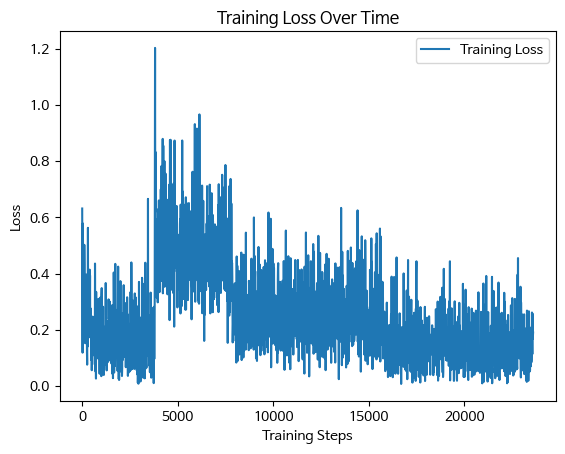

In [ ]:
import matplotlib.pyplot as plt


with open("training_log.json", "r") as f:
    log_data = json.load(f)


log_data = trainer.state.log_history

# Loss 값만 추출
steps = [entry["step"] for entry in log_data if "loss" in entry]
loss_values = [entry["loss"] for entry in log_data if "loss" in entry]

# 그래프 그리기
plt.plot(steps, loss_values, label="Training Loss")
plt.xlabel("Training Steps")
plt.ylabel("Loss")
plt.title("Training Loss Over Time")
plt.legend()
plt.show()

step별로 loss를 찍어보았을 때 training loss가 굉장히 요동치는 것을 확인할 수 있었지만 epoch으로 보면 그래도 감소하는 추세를 볼 수 있었습니다.

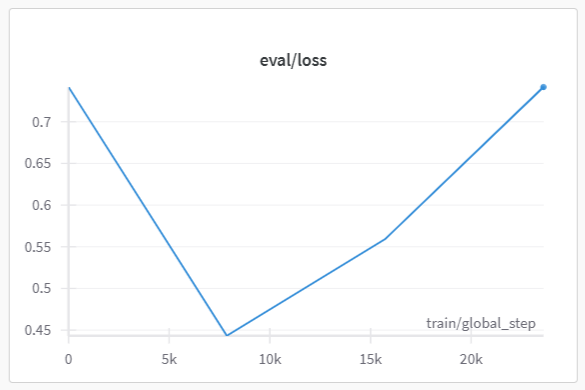

evaluation loss는 학습시킬수록 증가하는 추세를 보였습니다. 훈련 데이터셋에 과적합한 것 같기도 하며 learning rate 조절을 잘못한 것 같기도 하였습니다.



#3. 모델 평가

가장 마지막에 저장된 모델의 가중치를 로드하여 성능을 평가하였습니다.

평가 지표로는 EM과 F1 score를 사용하였습니다.  

>EM (Exact Match): 모델의 예측이 실제 정답과 완전히 일치하는 비율


In [ ]:
from transformers import AutoModelForQuestionAnswering, TrainingArguments, Trainer
import numpy as np
import torch
import evaluate

# 모델 및 토크나이저 로드
model_path = "./model/checkpoint-23592"
tokenizer = AutoTokenizer.from_pretrained("klue/bert-base")
model = AutoModelForQuestionAnswering.from_pretrained(model_path)

def compute_metrics(eval_pred):
    # 데이터셋에 맞는 SQuAD 지표를 활용해 평가
    metric = evaluate.load("squad")
    predictions, labels = eval_pred

    # 각 답변의 시작, 끝 위치 확률 분포
    start_logits, end_logits = predictions
    start_positions, end_positions = labels

    predicted_answers = []
    reference_answers = []

    for i in range(len(start_logits)):
        start_index = torch.argmax(torch.tensor(start_logits[i])).item()
        end_index = torch.argmax(torch.tensor(end_logits[i])).item()

        # 예측 답변과 실제 답변 decoding하여 비교
        predicted_answer = tokenizer.decode(tokenized_datasets["validation"][i]['input_ids'][start_index:end_index+1])
        reference_answer = tokenizer.decode(tokenized_datasets["validation"][i]['input_ids'][start_positions[i]:end_positions[i]+1])

        predicted_answers.append({"prediction_text": predicted_answer, "id": str(i)})
        reference_answers.append({"answers": {"text": [reference_answer], "answer_start": [start_positions[i]]}, "id": str(i)})

    results = metric.compute(predictions=predicted_answers, references=reference_answers)
    return results

# Trainer 설정
training_args = TrainingArguments(
    output_dir="./results",
    eval_strategy="epoch",
    learning_rate=2e-5,
    per_device_train_batch_size=16,
    per_device_eval_batch_size=16,
    num_train_epochs=3,
    weight_decay=0.01,
)

trainer = Trainer(
    model=model,
    args=training_args,
    train_dataset=tokenized_datasets["train"],
    eval_dataset=tokenized_datasets["validation"],
    compute_metrics=compute_metrics
)

# 평가 실행
results = trainer.evaluate()

print(f"Evaluation results: {results}")

predictions = trainer.predict(tokenized_datasets["validation"])
start_logits, end_logits = predictions.predictions

original_dataset = dataset["validation"]

# 모델 예측 답변 출력
for i in range(5):
    start_index = torch.argmax(torch.tensor(start_logits[i])).item()
    end_index = torch.argmax(torch.tensor(end_logits[i])).item()

    predicted_answer = tokenizer.decode(tokenized_datasets["validation"][i]['input_ids'][start_index:end_index+1])

    original_example = original_dataset[i]
    context = original_example['context']
    question = original_example['question']
    actual_answer = original_example['answers']['text'][0]

    print(f"Example {i+1}:")
    print(f"Context: {context}")
    print(f"Question: {question}")
    print(f"Predicted answer: {predicted_answer}")
    print(f"Actual answer: {actual_answer}")
    print()


/usr/gatoai/python/venv/3.10/lib/python3.10/site-packages/transformers/training_args.py:1594: FutureWarning: `evaluation_strategy` is deprecated and will be removed in version 4.46 of 🤗 Transformers. Use `eval_strategy` instead
  warnings.warn(
/tmp/ipykernel_5706/1520856959.py:56: FutureWarning: `tokenizer` is deprecated and will be removed in version 5.0.0 for `Trainer.__init__`. Use `processing_class` instead.
  trainer = Trainer(
Detected kernel version 3.10.0, which is below the recommended minimum of 5.5.0; this can cause the process to hang. It is recommended to upgrade the kernel to the minimum version or higher.


🏃 View run ./results at: http://127.0.0.1:5000/#/experiments/775327507505728817/runs/a072ea91698b4dc58edd2b064c85b7b2
🧪 View experiment at: http://127.0.0.1:5000/#/experiments/775327507505728817


Using the latest cached version of the module from /mnt/srv/home/SHARED/huggingface/cache/modules/evaluate_modules/metrics/evaluate-metric--squad/b4e2dbca455821c7367faa26712f378254b69040ebaab90b64bdeb465e4a304d (last modified on Sat Feb 22 23:02:23 2025) since it couldn't be found locally at evaluate-metric--squad, or remotely on the Hugging Face Hub.


Evaluation results: {'eval_loss': 0.7416792511940002, 'eval_model_preparation_time': 0.0034, 'eval_exact_match': 85.97887896019496, 'eval_f1': 91.12259155286071, 'eval_runtime': 70.3897, 'eval_samples_per_second': 87.442, 'eval_steps_per_second': 5.47}
Example 1:
Context: 1989년 2월 15일 여의도 농민 폭력 시위를 주도한 혐의(폭력행위등처벌에관한법률위반)으로 지명수배되었다. 1989년 3월 12일 서울지방검찰청 공안부는 임종석의 사전구속영장을 발부받았다. 같은 해 6월 30일 평양축전에 임수경을 대표로 파견하여 국가보안법위반 혐의가 추가되었다. 경찰은 12월 18일~20일 사이 서울 경희대학교에서 임종석이 성명 발표를 추진하고 있다는 첩보를 입수했고, 12월 18일 오전 7시 40분 경 가스총과 전자봉으로 무장한 특공조 및 대공과 직원 12명 등 22명의 사복 경찰을 승용차 8대에 나누어 경희대학교에 투입했다. 1989년 12월 18일 오전 8시 15분 경 서울청량리경찰서는 호위 학생 5명과 함께 경희대학교 학생회관 건물 계단을 내려오는 임종석을 발견, 검거해 구속을 집행했다. 임종석은 청량리경찰서에서 약 1시간 동안 조사를 받은 뒤 오전 9시 50분 경 서울 장안동의 서울지방경찰청 공안분실로 인계되었다.
Question: 임종석이 여의도 농민 폭력 시위를 주도한 혐의로 지명수배 된 날은?
Predicted answer: 1989년 2월 15일
Actual answer: 1989년 2월 15일

Example 2:
Context: 1989년 2월 15일 여의도 농민 폭력 시위를 주도한 혐의(폭력행위등처벌에관한법률위반)으로 지명수배되었다. 1989년 3월 12일 서울지방검찰청 공안부는 임종석의 사전구속영장을 발부받았다. 같은 해 6월 30일 평양

'eval_exact_match': 85.97887896019496, 'eval_f1': 91.12259155286071'로 높은 정확도로 예측한다는 것을 볼 수 있었습니다.

In [ ]:
for i in range(20):
    start_index = torch.argmax(torch.tensor(start_logits[i])).item()
    end_index = torch.argmax(torch.tensor(end_logits[i])).item()

    predicted_answer = tokenizer.decode(tokenized_datasets["validation"][i]['input_ids'][start_index:end_index+1])

    original_example = original_dataset[i]
    context = original_example['context']
    question = original_example['question']
    actual_answer = original_example['answers']['text'][0]

    print(f"Example {i+1}:")
    print(f"Context: {context}")
    print(f"Question: {question}")
    print(f"Predicted answer: {predicted_answer}")
    print(f"Actual answer: {actual_answer}")
    print()

Example 1:
Context: 1989년 2월 15일 여의도 농민 폭력 시위를 주도한 혐의(폭력행위등처벌에관한법률위반)으로 지명수배되었다. 1989년 3월 12일 서울지방검찰청 공안부는 임종석의 사전구속영장을 발부받았다. 같은 해 6월 30일 평양축전에 임수경을 대표로 파견하여 국가보안법위반 혐의가 추가되었다. 경찰은 12월 18일~20일 사이 서울 경희대학교에서 임종석이 성명 발표를 추진하고 있다는 첩보를 입수했고, 12월 18일 오전 7시 40분 경 가스총과 전자봉으로 무장한 특공조 및 대공과 직원 12명 등 22명의 사복 경찰을 승용차 8대에 나누어 경희대학교에 투입했다. 1989년 12월 18일 오전 8시 15분 경 서울청량리경찰서는 호위 학생 5명과 함께 경희대학교 학생회관 건물 계단을 내려오는 임종석을 발견, 검거해 구속을 집행했다. 임종석은 청량리경찰서에서 약 1시간 동안 조사를 받은 뒤 오전 9시 50분 경 서울 장안동의 서울지방경찰청 공안분실로 인계되었다.
Question: 임종석이 여의도 농민 폭력 시위를 주도한 혐의로 지명수배 된 날은?
Predicted answer: 1989년 2월 15일
Actual answer: 1989년 2월 15일

Example 2:
Context: 1989년 2월 15일 여의도 농민 폭력 시위를 주도한 혐의(폭력행위등처벌에관한법률위반)으로 지명수배되었다. 1989년 3월 12일 서울지방검찰청 공안부는 임종석의 사전구속영장을 발부받았다. 같은 해 6월 30일 평양축전에 임수경을 대표로 파견하여 국가보안법위반 혐의가 추가되었다. 경찰은 12월 18일~20일 사이 서울 경희대학교에서 임종석이 성명 발표를 추진하고 있다는 첩보를 입수했고, 12월 18일 오전 7시 40분 경 가스총과 전자봉으로 무장한 특공조 및 대공과 직원 12명 등 22명의 사복 경찰을 승용차 8대에 나누어 경희대학교에 투입했다. 1989년 12월 18일 오전 8시 15분 경 서울청량리경찰서는 호위 학생 5명과 함께 경희대학교 학생회관 건물 계

# 4. 결과 분석 및 고찰

klue/bert-base를 로딩했을 때 모델의 마지막 prediction weight가 초기화되어 해당 task에 맞게 훈련되어야 한다는 경고가 발생했습니다. finetuning을 진행한 결과 모델이 높은 예측 정확도를 보이는 것을 확인하였습니다.

위의 예시를 보면 거의 모든 답을 맞추거나 정답이 '로널드 레이건 대통령'이면 '로널드 레이건'을 예측한다는 등 아쉽게 틀린 것도 있었습니다. 이를 통해 모델이 task에 대해 이해를 잘 하고 있음을 알 수 있었고, transformer 모델의 위력을 확인할 수 있었습니다.

Validation loss가 계속해서 증가해서 성능을 기대하지 않았음에도 불구하고 높은 정확도를 보여 성능을 개선할 여지가 있음을 느꼈습니다.

또한, tokenizing의 중요성을 깨닫게 되었습니다. 문장이 길어질 경우 단순히 잘라내는 방법만 생각했는데, 슬라이딩 윈도우 방식을 통해 잘린 부분도 학습할 수 있도록 하는 접근이 인상적이었습니다.

이 과제를 통해 LLM 태스크를 수행할 때 데이터 전처리가 얼마나 중요한지를 깊이 있게 이해할 수 있었습니다.